In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **Etude FAO**
# La sous-nutrition dans le monde

## Récupération des données

Dans le cadre de ce projet, on dispose de 4 fichiers extraits du site https://www.fao.org/faostat/fr/#data :
   - population.csv
   - dispo_alimentaire.csv
   - aide_alimentaire.csv
   - sous_nutrition.csv

### Importation des fichiers

In [2]:
# fonction de convertion des milliers
def f_convert_millier(df, col):
    df[col] = df[col].astype('Float64')
    df[col] *= 1000
    df[col] = df[col].astype('Int64')
    
# end def

# fonction de formatage des noms de pays (pays ayant des noms différents selon les tables)
def f_formatPays(df):
    def f_fonctionFormat(nomARemplacer, nouveauNom):
        df.loc[df['Zone'] == nomARemplacer, 'Zone'] = nouveauNom
    #Royaume-Uni
    f_fonctionFormat("Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", "Royaume-Uni")
    #Tchéquie
    f_fonctionFormat("Tchéquie (la)", "Tchéquie")
    #Pour distinguer plus facilement les deux Corée, on les renomme également:
    #Corée du Nord
    f_fonctionFormat("République populaire démocratique de Corée", "Corée du Nord")
    #Corée du Sud
    f_fonctionFormat("République de Corée", "Corée du Sud")

In [3]:
#### Table population

df_population = pd.read_csv('./data/population.csv')

# La population est en milliers d'habitant, on la remet à l'unité :
f_convert_millier(df_population, 'Valeur')

# Le champ 'Valeur' ne renseigne pas sur le contenu de la série :
df_population.rename(columns={'Valeur': 'Population'}, inplace=True)

f_formatPays(df_population)

# Création d'une table pour l'année 2017 pour les analyses demandées:
df_population2017 = df_population.loc[df_population['Année'] == 2017, ['Zone', 'Population']]

#### Table disponibilité alimentaire

df_dispoAlimentaire = pd.read_csv('./data/dispo_alimentaire.csv')

# Les données où l'unité n'est pas précisée dans le libellé sont en milliers de tonnes, on les remet à la tonne :
# liste des champs à modifier
l_variables = ['Aliments pour animaux', 'Autres Utilisations', 'Disponibilité intérieure', 'Exportations - Quantité', 
             'Importations - Quantité', 'Nourriture', 'Pertes', 'Production', 'Semences', 'Traitement', 'Variation de stock']

# boucle sur chaque champ pour appliquer les modifications
for var in l_variables:
    f_convert_millier(df_dispoAlimentaire, var)
    df_dispoAlimentaire.rename(columns={var: var + " (t)"}, inplace=True)
    
f_formatPays(df_dispoAlimentaire)
    
# La table ne contient que 2017

#### Table sous-nutrition

df_sousNutrition = pd.read_csv('./data/sous_nutrition.csv')

# On commence par remettre l'année au bon 'format' :
df_sousNutrition['Année'].replace({'2012-2014': 2013, '2013-2015': 2014, '2014-2016': 2015, '2015-2017': 2016, 
                                '2016-2018': 2017, '2017-2019': 2018}, inplace=True)

# Le champ 'Valeur' est un objet, et il n'est pas possible de le convertir en float, à cause de la présence de '<0.1'
df_sousNutrition.loc[df_sousNutrition['Valeur'] == '<0.1', 'Valeur'] = '0'

# remettre à 0 les données manquantes :
df_sousNutrition.loc[df_sousNutrition['Valeur'].isnull(), 'Valeur'] = 0

# Le nombre d'habitants est exprimé en millions, on le remet à l'unité :
df_sousNutrition['Valeur'] = df_sousNutrition['Valeur'].astype('Float64')
df_sousNutrition.loc[df_sousNutrition['Valeur'].isnull(), 'Valeur'] = 0
df_sousNutrition['Valeur'] *= 1000000
df_sousNutrition['Valeur'] = df_sousNutrition['Valeur'].astype('Int64')

# On remet un libellé plus évocateur pour la colonne 'Valeur' :
df_sousNutrition.rename(columns={'Valeur': 'Population en sous-nutrition'}, inplace=True)

f_formatPays(df_sousNutrition)

# Création d'une table pour 2017 pour les analyses :
df_sousNutrition2017 = df_sousNutrition.loc[df_sousNutrition['Année'] == 2017, ['Zone', 'Population en sous-nutrition']]

#### Table aide alimentaire

df_aideAlimentaire = pd.read_csv('./data/aide_alimentaire.csv')

# Il n'y a qu'à renommer les séries 'Pays bénéficiaire' et 'Valeur' :
df_aideAlimentaire.rename(columns={'Pays bénéficiaire': 'Zone', 'Valeur': 'Aide alimentaire (t)'}, inplace=True)

f_formatPays(df_aideAlimentaire)

#### liste pays continent

# lecture de la table pays
df_pays = pd.read_csv('./data/liste_pays.csv')
df_pays = df_pays[['Pays', 'Code ISO2']]
df_pays.columns = ['Zone', 'Code ISO2']

# lecture de la table continent
df_continent = pd.read_json('./data/continent.json', orient='index')
df_continent.reset_index(inplace=True)
df_continent.columns = ['Code ISO2', 'Code continent']

# jointure des deux
df_paysContinent = pd.merge(df_pays, df_continent)
del df_pays, df_continent

f_formatPays(df_paysContinent)

# mappage des continents
df_paysContinent['Continent'] = df_paysContinent['Code continent'].map({'AS': 'Asie', 
                                                                        'AF': 'Afrique', 
                                                                        'EU': 'Europe', 
                                                                        'NA': 'Amérique du Nord',
                                                                        'SA': 'Amérique du Sud', 
                                                                        'AN': 'Antartique', 
                                                                        'OC': 'Océanie'})
df_paysContinent = df_paysContinent[['Zone', 'Continent']]

#### On a donc le dataset suivant

display(df_population2017.head())
display(df_dispoAlimentaire.head())
display(df_sousNutrition2017.head())
display(df_aideAlimentaire.head())
display(df_paysContinent.head())

,Zone,Population
4,Afghanistan,36296113
10,Afrique du Sud,57009756
16,Albanie,2884169
22,Algérie,41389189
28,Allemagne,82658409


,Zone,Produit,Origine,Aliments pour animaux (t),Autres Utilisations (t),Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure (t),Exportations - Quantité (t),Importations - Quantité (t),Nourriture (t),Pertes (t),Production (t),Semences (t),Traitement (t),Variation de stock (t)
0,Afghanistan,Abats Comestible,animale,<NA>,<NA>,5.0,1.72,0.20,0.77,53000,<NA>,<NA>,53000,<NA>,53000,<NA>,<NA>,<NA>
1,Afghanistan,"Agrumes, Autres",vegetale,<NA>,<NA>,1.0,1.29,0.01,0.02,41000,2000,40000,39000,2000,3000,<NA>,<NA>,<NA>
2,Afghanistan,Aliments pour enfants,vegetale,<NA>,<NA>,1.0,0.06,0.01,0.03,2000,<NA>,2000,2000,<NA>,<NA>,<NA>,<NA>,<NA>
3,Afghanistan,Ananas,vegetale,<NA>,<NA>,0.0,0.00,NaN,NaN,0,<NA>,0,0,<NA>,<NA>,<NA>,<NA>,<NA>
4,Afghanistan,Bananes,vegetale,<NA>,<NA>,4.0,2.70,0.02,0.05,82000,<NA>,82000,82000,<NA>,<NA>,<NA>,<NA>,<NA>


,Zone,Population en sous-nutrition
4,Afghanistan,10500000
10,Afrique du Sud,3100000
16,Albanie,100000
22,Algérie,1300000
28,Allemagne,0


,Zone,Année,Produit,Aide alimentaire (t)
0,Afghanistan,2013,Autres non-céréales,682
1,Afghanistan,2014,Autres non-céréales,335
2,Afghanistan,2013,Blé et Farin,39224
3,Afghanistan,2014,Blé et Farin,15160
4,Afghanistan,2013,Céréales,40504


,Zone,Continent
0,Afghanistan,Asie
1,Afrique du Sud,Afrique
2,Albanie,Europe
3,Algérie,Afrique
4,Allemagne,Europe


## Traitement des requêtes

In [4]:
# paramètres généraux pour les graphiques
sns.set_theme(style="white")
plt.rc('axes', titlesize=14, titleweight='bold')
plt.rc('figure', autolayout=True, figsize=(9,5))

### 1. La proportion de personnes en état de sous-nutrition.

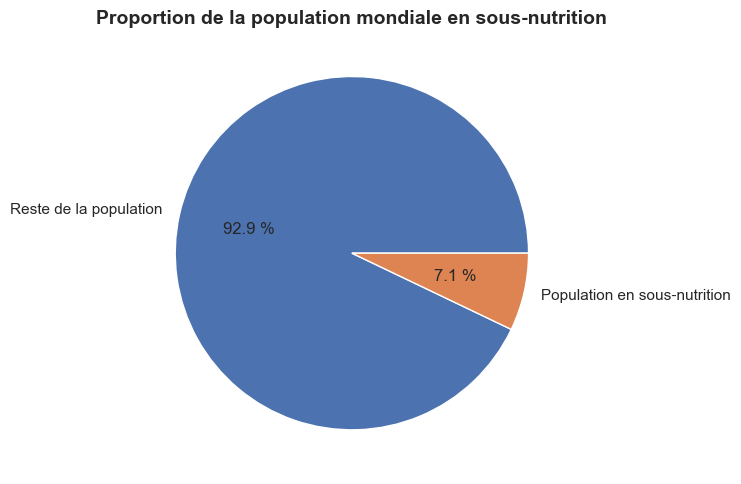

La population mondiale en sous-nutrition représente 535_700_000 personnes.


In [5]:
# regroupement des tables population et sous-nutrition, sur la table population pour garder l'information totale de la population mondiale
df_populationSousNutrition = pd.merge(df_population2017, df_sousNutrition2017[['Zone', 'Population en sous-nutrition']], how='left')
df_populationSousNutrition['Reste de la population'] = df_populationSousNutrition['Population'] - df_populationSousNutrition['Population en sous-nutrition']

# données pour le graphique
data = pd.melt(df_populationSousNutrition[['Zone', 'Reste de la population', 'Population en sous-nutrition']], id_vars='Zone', var_name='Indicateur', value_name='Nombre de personnes')
data = data.groupby('Indicateur', as_index=False).sum()
data.sort_values('Indicateur', ascending=False, inplace=True)

# construction du graphique
plt.figure()
plt.pie(data['Nombre de personnes'], autopct='%.1f %%', labels=data['Indicateur'])
plt.title('Proportion de la population mondiale en sous-nutrition')
plt.show()

# variables
populationEnSousNutrition = data.loc[data['Indicateur'] == 'Population en sous-nutrition', 'Nombre de personnes'].sum()

print("La population mondiale en sous-nutrition représente", "{:_}".format(populationEnSousNutrition), "personnes.")

Examinons la situation selon les continents :

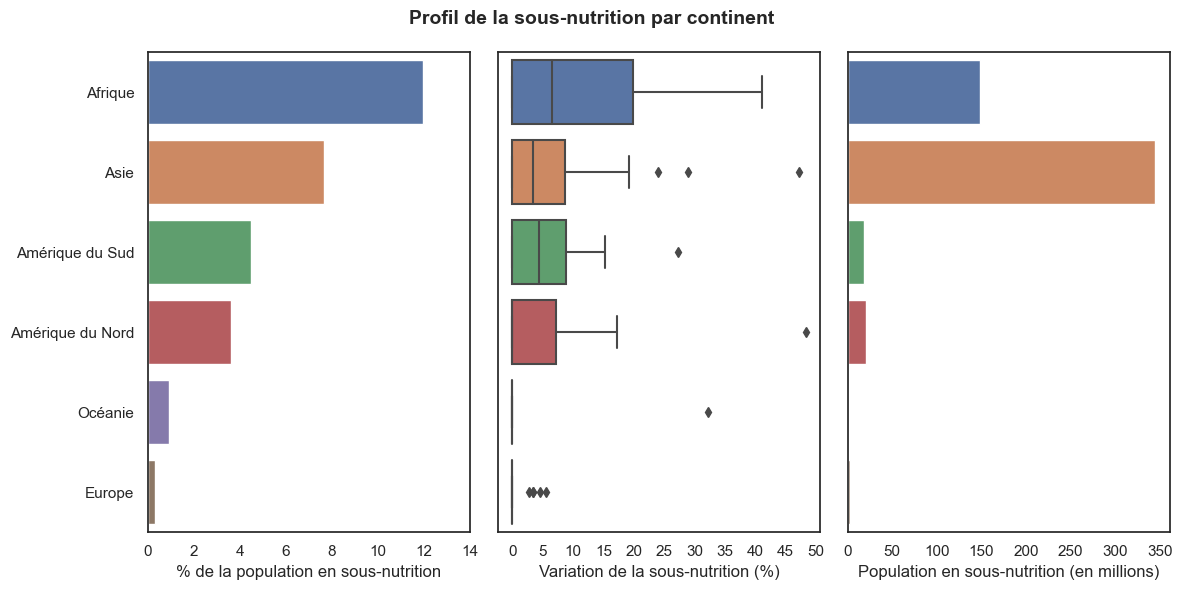

In [6]:
# on ajoute le calcul par pays
df_populationSousNutrition['% sous-nutrition'] = df_populationSousNutrition['Population en sous-nutrition'] / df_populationSousNutrition['Population']

# on ajoute le continent
data = pd.merge(df_populationSousNutrition, df_paysContinent, how='left')

# regroupement pour pouvoir classer les continents
data_group = data.groupby('Continent', as_index=False).sum(numeric_only=True)
data_group['% sous-nutrition'] = data_group['Population en sous-nutrition'] / data_group['Population']
data_group.sort_values('% sous-nutrition', ascending=False, inplace=True)

# découpage en 3 de la fenêtre
plt.subplots(1, 3, sharey=True, figsize=(12,6))
plt.suptitle("Profil de la sous-nutrition par continent", fontsize=14, fontweight='bold')

# % de sous-nutrition global
plt.subplot(131)
sns.barplot(data=data_group, x='% sous-nutrition', y='Continent', estimator=sum, ci=False)
plt.xlabel("% de la population en sous-nutrition")
plt.xticks(np.arange(0, 0.16, 0.02), np.arange(0, 16, 2))
plt.ylabel(None)

# amplitude de la sous-nutrition
plt.subplot(132)
sns.boxplot(data=data, x='% sous-nutrition', y='Continent', order=data_group['Continent'])
plt.xlabel("Variation de la sous-nutrition (%)")
plt.xticks(np.arange(0, 0.55, 0.05), np.arange(0, 55, 5))
plt.ylabel(None)

# nombre de personnes concernées
plt.subplot(133)
sns.barplot(data=data_group, x='Population en sous-nutrition', y='Continent', estimator=sum, ci=False)
plt.xlabel("Population en sous-nutrition (en millions)")
plt.xticks(np.arange(0, 400000000, 50000000), np.arange(0, 400, 50))
plt.ylabel(None)

plt.show()

### 2. Le nombre théorique de personnes qui pourraient être nourries.
(calculer à partir de la disponibilité alimentaire)

"Pour un homme adulte, l'apport conseillé en énergie est, en moyenne, de 2 400 à 2 600 calories par jour, selon l'activité. Pour une femme adulte, il est de 1 800 à 2 200 calories."

https://www.vidal.fr/sante/nutrition/equilibre-alimentaire-adulte/recommandations-nutritionnelles-adulte.html

Pour les calculs, nous partirons sur les valeurs hautes, pour ne pas surestimer le nombre de personnes, et considérons qu'il y a environ 50% de femmes et d'hommes.

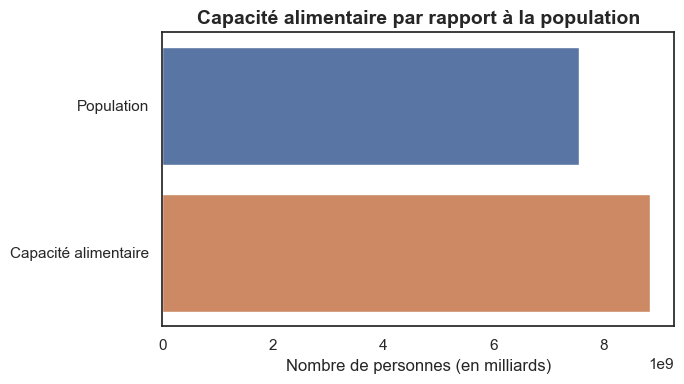

Le total des calories disponibles à la nutrition pourrait permettre d'alimenter : 8_825_901_057 personnes,
soit 117% de la population.


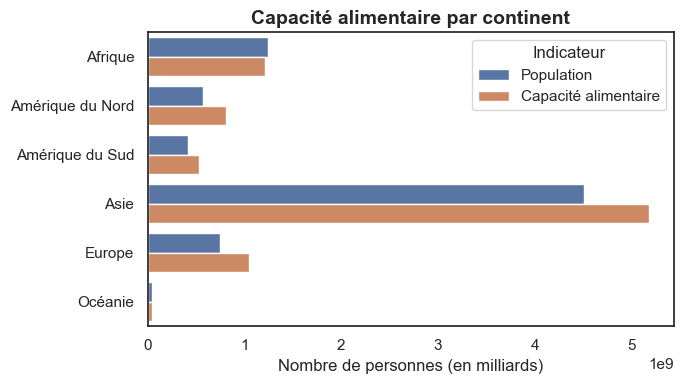

In [7]:
# détermination du besoin en calories moyen
besoinCalorieJour = np.mean([2200, 2600])

# déterminer le nombre de calories disponibles au niveau mondial pour trouver le nombre de personnes que l'on pourrait nourrir.

# total des informations de la table dispoAlimentaire par pays
df_dispoAlimentairePays = df_dispoAlimentaire.groupby(['Zone'], as_index=False).sum(numeric_only=True)

# on ne garde que la variable 'Disponibilité alimentaire (Kcal/personne/jour)' et on ajoute la population pour pouvoir avoir le total disponible par jour
df_dispoAlimentairePays = pd.merge(df_dispoAlimentairePays[['Zone', 'Disponibilité alimentaire (Kcal/personne/jour)']], df_population2017, how='right')
df_dispoAlimentairePays['Disponibilité alimentaire (Kcal/jour)'] = df_dispoAlimentairePays['Disponibilité alimentaire (Kcal/personne/jour)'] * df_dispoAlimentairePays['Population']
df_dispoAlimentairePays['Capacité alimentaire (nb personnes)'] = df_dispoAlimentairePays['Disponibilité alimentaire (Kcal/jour)'] / besoinCalorieJour

data = df_dispoAlimentairePays[['Zone', 'Population', 'Capacité alimentaire (nb personnes)']]
data.columns = ['Zone', 'Population', 'Capacité alimentaire']
data = pd.melt(data, id_vars='Zone', var_name='Indicateur', value_name='Nombre de personnes')


# construction du graphique
plt.figure(figsize=(7,4))
sns.barplot(data=data, y='Indicateur', x='Nombre de personnes', estimator=sum, ci=False)
plt.title("Capacité alimentaire par rapport à la population")
plt.xlabel("Nombre de personnes (en milliards)")
plt.ylabel("")

plt.show()

# calculs pour répondre à la question
populationMondiale = df_population2017['Population'].sum()
capacite = round(df_dispoAlimentairePays.loc[df_dispoAlimentairePays['Capacité alimentaire (nb personnes)'].notnull(), 'Capacité alimentaire (nb personnes)'].astype('Int64').sum())
ratioCapacite = capacite / populationMondiale

print("Le total des calories disponibles à la nutrition pourrait permettre d'alimenter :",
      "{:_}".format(capacite), "personnes,\nsoit", "{:.0%}".format(ratioCapacite), "de la population.")

# on regarde la répartition selon les continents
df_dispoAlimentaireContinent = pd.merge(df_dispoAlimentairePays, df_paysContinent, how='left')
df_dispoAlimentaireContinent = df_dispoAlimentaireContinent.groupby('Continent', as_index=False).sum(numeric_only=True)

data = df_dispoAlimentaireContinent[['Continent', 'Population', 'Capacité alimentaire (nb personnes)']]
data.columns = ['Continent', 'Population', 'Capacité alimentaire']
data = pd.melt(data, id_vars='Continent', var_name='Indicateur', value_name='Nombre de personnes')


# construction du graphique
plt.figure(figsize=(7,4))
sns.barplot(data=data, y='Continent', x='Nombre de personnes', hue='Indicateur', estimator=sum, ci=False)
plt.title("Capacité alimentaire par continent")
plt.xlabel("Nombre de personnes (en milliards)")
plt.ylabel("")
plt.show()

### 3. Le nombre théorique de personnes qui pourraient être nourries.
(calculer à partir de la disponibilité alimentaire **végétale**)

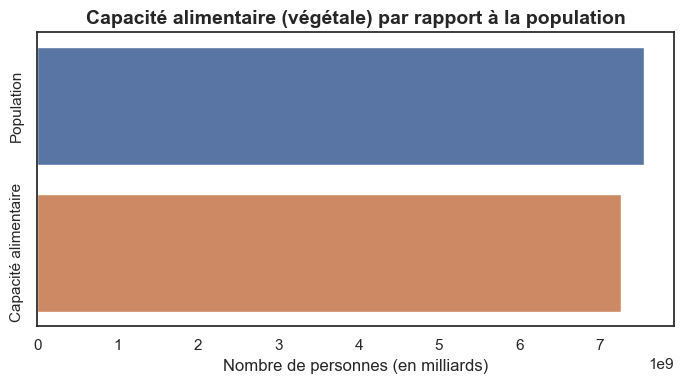

Le total des calories d'origine végétale disponibles à la nutrition pourrait permettre d'alimenter : 7_270_628_833 personnes,
soit 96% de la population.


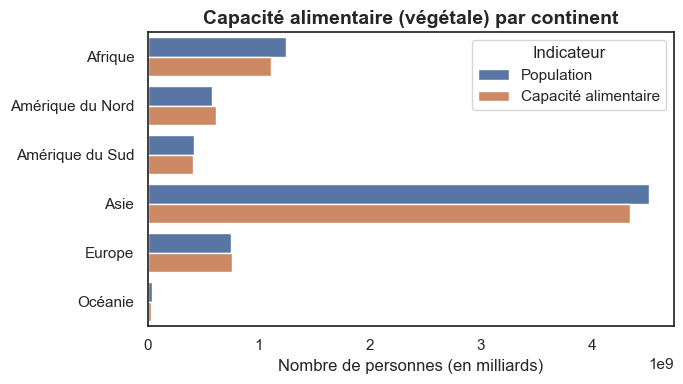

In [8]:
# on part sur le même calcul mais en ajoutant l'origine des produits pour filtrer les produits d'origine végétale :

# total des informations de la table dispoAlimentaire par pays, en ne gardant que les produits d'origine végétale
df_dispoAlimentaireVegetalePays = df_dispoAlimentaire.groupby(['Zone', 'Origine'], as_index=False)['Disponibilité alimentaire (Kcal/personne/jour)'].sum(numeric_only=True)
df_dispoAlimentaireVegetalePays = df_dispoAlimentaireVegetalePays.loc[df_dispoAlimentaireVegetalePays['Origine'] == 'vegetale', :]

# on ne garde que la variable 'Disponibilité alimentaire (Kcal/personne/jour)' et on ajoute la population pour pouvoir avoir le total disponible par jour
df_dispoAlimentaireVegetalePays = pd.merge(df_dispoAlimentaireVegetalePays[['Zone', 'Disponibilité alimentaire (Kcal/personne/jour)']], df_population2017, how='right')
df_dispoAlimentaireVegetalePays['Disponibilité alimentaire (Kcal/jour)'] = df_dispoAlimentaireVegetalePays['Disponibilité alimentaire (Kcal/personne/jour)'] * df_dispoAlimentaireVegetalePays['Population']
df_dispoAlimentaireVegetalePays['Capacité alimentaire (nb personnes)'] = df_dispoAlimentaireVegetalePays['Disponibilité alimentaire (Kcal/jour)'] / besoinCalorieJour

data = df_dispoAlimentaireVegetalePays[['Zone', 'Population', 'Capacité alimentaire (nb personnes)']]
data.columns = ['Zone', 'Population', 'Capacité alimentaire']
data = pd.melt(data, id_vars='Zone', var_name='Indicateur', value_name='Nombre de personnes')

# construction du graphique
plt.figure(figsize=(7,4))
sns.barplot(data=data, y='Indicateur', x='Nombre de personnes', estimator=sum, ci=False)
plt.title("Capacité alimentaire (végétale) par rapport à la population")
plt.xlabel("Nombre de personnes (en milliards)")
plt.ylabel("")
plt.yticks(rotation=90, verticalalignment='center')
plt.show()

# calculs pour répondre à la question
capaciteVegetale = round(df_dispoAlimentaireVegetalePays.loc[df_dispoAlimentaireVegetalePays['Capacité alimentaire (nb personnes)'].notnull(), 'Capacité alimentaire (nb personnes)'].astype('Int64').sum())
ratioCapaciteVegetale = capaciteVegetale / populationMondiale

print("Le total des calories d'origine végétale disponibles à la nutrition pourrait permettre d'alimenter :",
      "{:_}".format(capaciteVegetale), "personnes,\nsoit", "{:.0%}".format(ratioCapaciteVegetale), "de la population.")

# on regarde la répartition selon les continents
df_dispoAlimentaireVegetaleContinent = pd.merge(df_dispoAlimentaireVegetalePays, df_paysContinent, how='left')
df_dispoAlimentaireVegetaleContinent = df_dispoAlimentaireVegetaleContinent.groupby('Continent', as_index=False).sum(numeric_only=True)

data = df_dispoAlimentaireVegetaleContinent[['Continent', 'Population', 'Capacité alimentaire (nb personnes)']]
data.columns = ['Continent', 'Population', 'Capacité alimentaire']
data = pd.melt(data, id_vars='Continent', var_name='Indicateur', value_name='Nombre de personnes')


# construction du graphique
plt.figure(figsize=(7,4))
sns.barplot(data=data, y='Continent', x='Nombre de personnes', hue='Indicateur', estimator=sum, ci=False)
plt.title("Capacité alimentaire (végétale) par continent")
plt.xlabel("Nombre de personnes (en milliards)")
plt.ylabel("")
plt.show()

### 4. L’utilisation de la disponibilité intérieure.

L'équation pour avoir le lien entre les variables est la suivante :

ressources = disponibilité intérieure = utilisations

    ressources = production + importation - exportation + variation de stock
    utilisations = nourriture + aliments pour animaux + autres Utilisations + pertes + semences + traitement

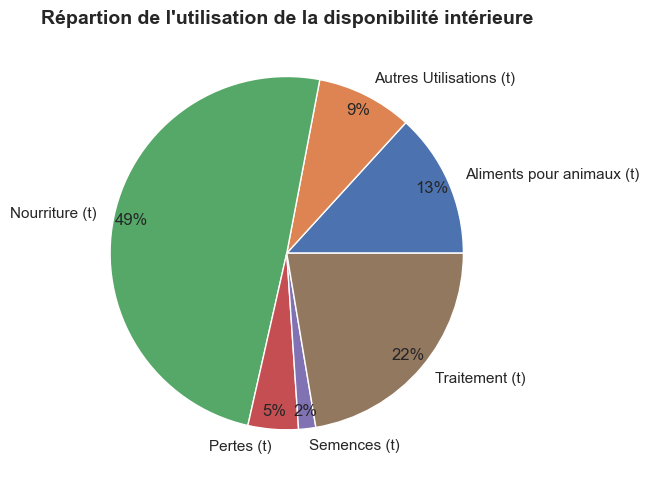

In [9]:
l_utilisations = ['Nourriture (t)', 'Aliments pour animaux (t)','Autres Utilisations (t)', 'Pertes (t)', 'Semences (t)', 'Traitement (t)']

# données en liste pour le graphique
data = pd.melt(df_dispoAlimentaire[l_utilisations], var_name="Indicateur", value_name="Tonnes")
data = data.groupby('Indicateur', as_index=False).sum()

# construction du graphique
plt.figure()
plt.pie(data['Tonnes'], autopct='%.0f%%',pctdistance= 0.9, labels=data['Indicateur'])
plt.title("Répartion de l'utilisation de la disponibilité intérieure")
plt.show()

### 5. Répartition de l'utilisation intérieure des céréales,
en particulier entre l'alimentation humaine et animale.

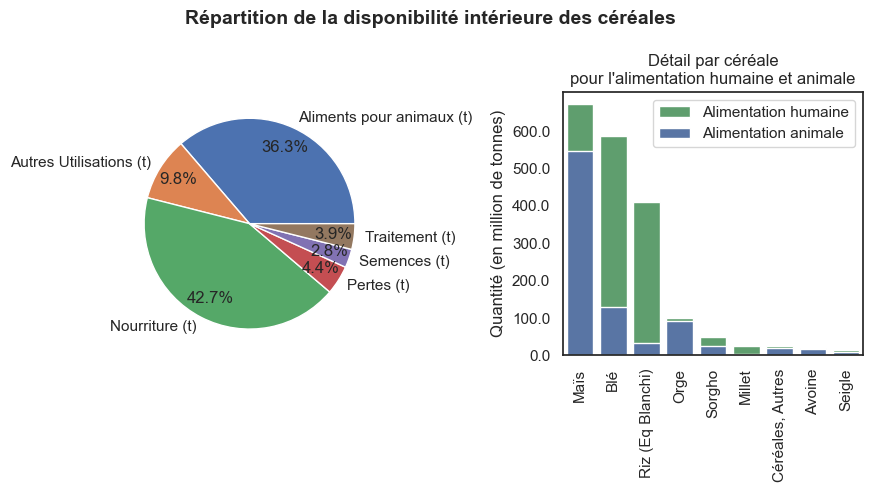

In [10]:
# liste des céréales récupérée via une autre extraction sur le site de la FAO
l_cereales = ['Blé',
              'Riz (Eq Blanchi)',
              'Orge',
              'Maïs',
              'Seigle',
              'Avoine',
              'Millet',
              'Sorgho',
              'Céréales, Autres']

# on filtre la table dispoAlimentaire sur les produits figurant dans la liste des céréales
df_dispoCereales = df_dispoAlimentaire.loc[df_dispoAlimentaire['Produit'].isin(l_cereales), :]
df_dispoCereales = df_dispoCereales.groupby('Produit', as_index=False).sum(numeric_only=True)

# on remet à plat pour le graphique
data = pd.melt(df_dispoCereales[l_utilisations], var_name='Indicateur', value_name='Tonnes')
data = data.groupby('Indicateur', as_index=False).sum()

# découpage de la fenêtre en 2
plt.subplots(1, 2)
plt.suptitle("Répartition de la disponibilité intérieure des céréales", fontsize=14, fontweight='bold')

# construction du graphique au niveau global
plt.subplot(121)
plt.pie(data['Tonnes'], autopct='%.1f%%', pctdistance=0.8, labels=data['Indicateur'])

# ajout du total pour un graphique par produit
df_dispoCereales['Total'] = df_dispoCereales['Aliments pour animaux (t)'] + df_dispoCereales ['Nourriture (t)']
df_dispoCereales.sort_values('Total', ascending=False, inplace=True)

# construction du graphique par produit
plt.subplot(122)
s1 = sns.barplot(data=df_dispoCereales[['Produit', 'Total']], x='Produit', y='Total', ci=False, color='#55A868', label='Alimentation humaine')
s2 = sns.barplot(data=df_dispoCereales[['Produit', 'Aliments pour animaux (t)']], 
                 x='Produit', 
                 y='Aliments pour animaux (t)', 
                 ci=False, 
                 color='#4C72B0',
                 label="Alimentation animale")
plt.title("Détail par céréale\npour l'alimentation humaine et animale", fontsize=12, fontweight='normal')
plt.legend()
plt.xlabel('')
plt.xticks(rotation=90)
plt.ylabel("Quantité (en million de tonnes)")
plt.yticks(np.arange(0, df_dispoCereales['Total'].max(), 100000000), np.arange(0, df_dispoCereales['Total'].max() / 1000000, 100))

plt.show()

### 6. L'utilisation du manioc par la Thaïlande,
aux égards de la proportion de personnes en sous-nutrition.

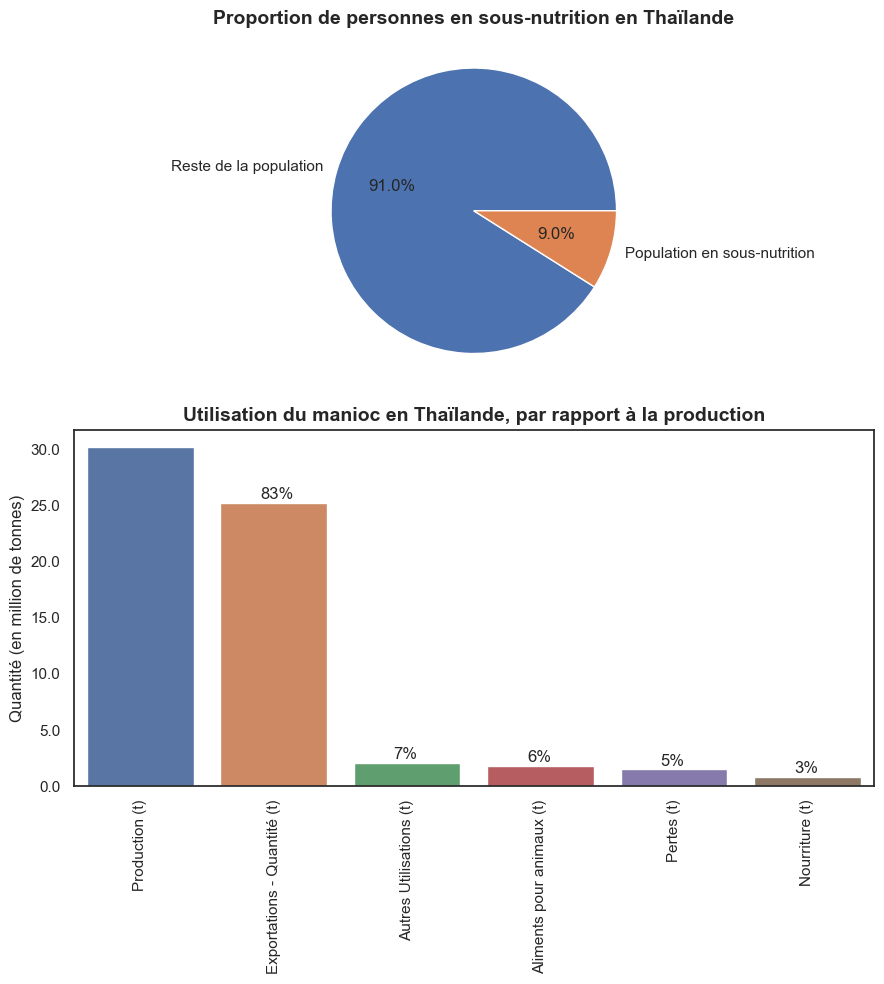

In [11]:
# A partir de la table populationSousNutrition, on récupère les infos de la Thaïlande
df_sousNutritionThailande = df_populationSousNutrition.loc[df_populationSousNutrition['Zone'] == 'Thaïlande', :]

# On remet les infos en liste pour le graphique
data = pd.melt(df_sousNutritionThailande[['Zone', 'Population', 'Population en sous-nutrition', 'Reste de la population']], id_vars='Zone', var_name='Indicateur', value_name="Nombre de personnes")[1:]
data.sort_values('Indicateur', ascending=False, inplace=True)

# pourcentage de la population en sous-nutrition
plt.subplots(2, 1, figsize=(9,10))
plt.subplot(211)
plt.pie(data['Nombre de personnes'], autopct='%.1f%%', labels=data['Indicateur'])
plt.title("Proportion de personnes en sous-nutrition en Thaïlande")

# A partir de la table dispoAlimentaire, on récupère les infos de la Thaïlande
df_dispoManiocThailande = df_dispoAlimentaire.loc[(df_dispoAlimentaire['Zone'] == "Thaïlande") & (df_dispoAlimentaire['Produit'] == 'Manioc'), :]

# On remet les infos en liste pour le graphique
data = df_dispoManiocThailande[['Production (t)', 'Exportations - Quantité (t)', 'Nourriture (t)', 'Aliments pour animaux (t)','Autres Utilisations (t)', 'Pertes (t)']]
data = pd.melt(data, var_name='Indicateur', value_name='Tonnes')
data.sort_values('Tonnes', ascending=False, inplace=True)

# construction du graphique
plt.subplot(212)
sns.barplot(data=data, x='Indicateur', y='Tonnes')
plt.title("Utilisation du manioc en Thaïlande, par rapport à la production")
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("Quantité (en million de tonnes)")
plt.yticks(np.arange(0, data['Tonnes'].max(), 5000000), np.arange(0, data['Tonnes'].max()/1000000, 5))  # Set label locations.
px=0.9
for p in data['Indicateur'][1:]:
    plt.annotate("{:.0%}".format(data.loc[data['Indicateur'] == p, 'Tonnes'].values[0] / data.loc[data['Indicateur'] == 'Production (t)', 'Tonnes'].values[0]), 
                 xy=(px,data.loc[data['Indicateur'] == p, 'Tonnes'].values[0]+350000))
    px +=1

plt.show()

###  6. Les pays pour lesquels la proportion de personnes sous-alimentées est la plus forte en 2017.

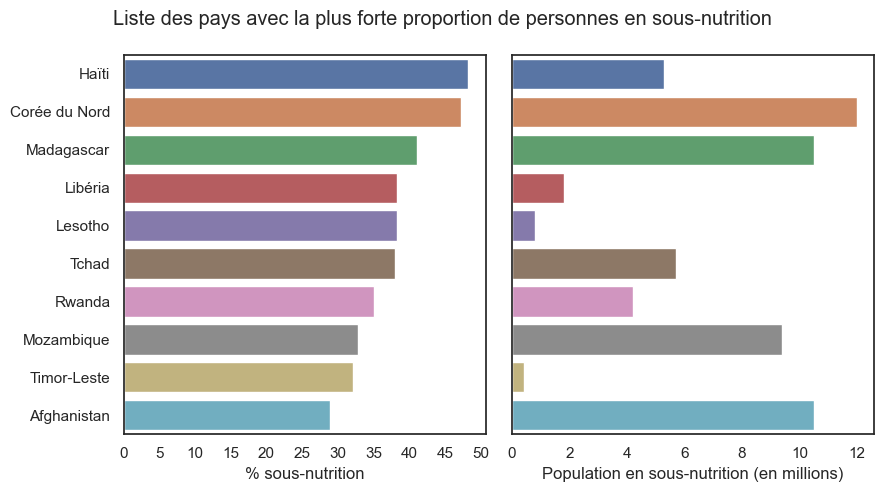

In [12]:
# on récupère les 10 pays avec le plus haut pourcentage
data = df_populationSousNutrition.sort_values('% sous-nutrition', ascending=False).head(10)

# graphique
plt.subplots(1, 2, sharey=True)
plt.suptitle("Liste des pays avec la plus forte proportion de personnes en sous-nutrition")

plt.subplot(121)
sns.barplot(data=data[['Zone', '% sous-nutrition']], y='Zone', x='% sous-nutrition', ci=False)
plt.xticks(np.arange(0, 0.55, 0.05), np.arange(0, 55, 5))
plt.ylabel(None)

plt.subplot(122)
sns.barplot(data=data[['Zone', 'Population en sous-nutrition']], y='Zone', x='Population en sous-nutrition', ci=False)
plt.xticks(np.arange(0, 14000000, 2000000), np.arange(0, 14, 2))
plt.xlabel("Population en sous-nutrition (en millions)")
plt.ylabel('')
plt.yticks(None)
    
plt.show()

### 7. Les pays qui ont le plus bénéficié d’aide depuis 2013.

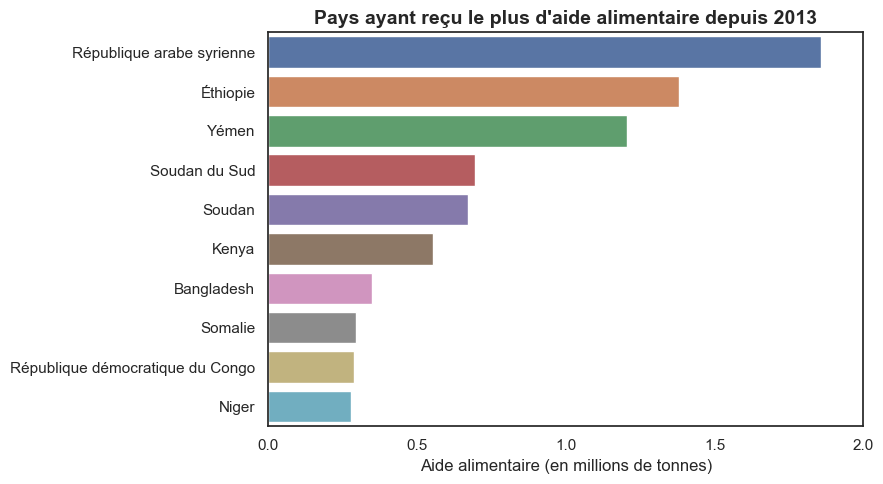

In [13]:
# on récupère les 10 pays ayant reçu le plus d'aide en faisant la somme depuis 2013
data = df_aideAlimentaire.loc[df_aideAlimentaire['Année'] >= 2013, ['Zone', 'Aide alimentaire (t)']].groupby('Zone', as_index=False).sum(numeric_only=True).sort_values('Aide alimentaire (t)', ascending=False).head(10)

# graphiqiue
plt.figure()
plt.title("Pays ayant reçu le plus d'aide alimentaire depuis 2013")
sns.barplot(data=data, x='Aide alimentaire (t)', y='Zone')
plt.ylabel(None)
plt.xlabel("Aide alimentaire (en millions de tonnes)")
plt.xticks(np.arange(0, 2500000, 500000), np.arange(0, 2.5, 0.5))
plt.show()

### 8. Pays ayant le plus/le moins de disponibilité/habitant

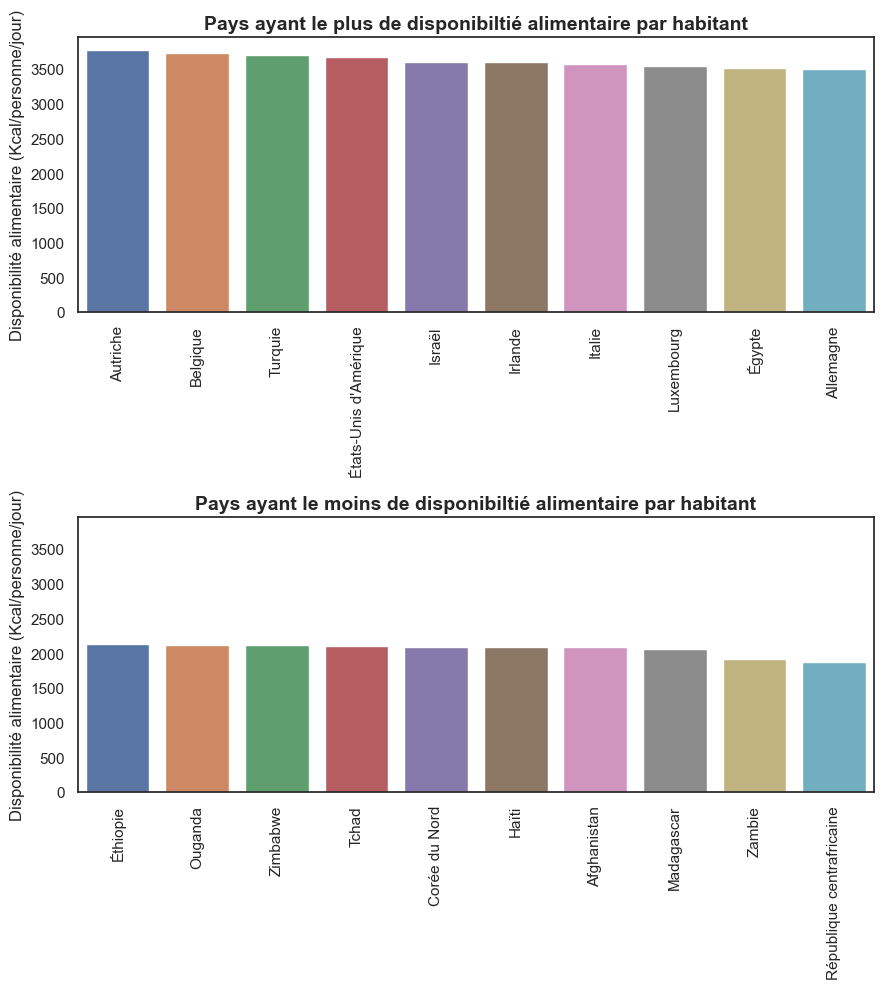

In [14]:
# on récupère le total des calories par pays à partir de la table dispoAlimentaire
df_dispoParHabitant = df_dispoAlimentaire.loc[df_dispoAlimentaire['Disponibilité alimentaire (Kcal/personne/jour)'].notnull(), ['Zone', 'Disponibilité alimentaire (Kcal/personne/jour)']].groupby('Zone', as_index=False).sum()

# on filtre ensuite le top et le bottom
data_head = df_dispoParHabitant.sort_values('Disponibilité alimentaire (Kcal/personne/jour)', ascending=False).head(10)
data_tail = df_dispoParHabitant.sort_values('Disponibilité alimentaire (Kcal/personne/jour)', ascending=False).tail(10)

# graphique
plt.subplots(2, 1, figsize=(9, 10), sharey=True)

# top
plt.subplot(211)
plt.title("Pays ayant le plus de disponibiltié alimentaire par habitant")
sns.barplot(data=data_head, y='Disponibilité alimentaire (Kcal/personne/jour)', x='Zone')
plt.xlabel(None)
plt.xticks(rotation=90)

# bottom
plt.subplot(212)
plt.title("Pays ayant le moins de disponibiltié alimentaire par habitant")
sns.barplot(data=data_tail, y='Disponibilité alimentaire (Kcal/personne/jour)', x='Zone')
plt.xlabel(None)
plt.xticks(rotation=90)

plt.show()